In [1]:
#!pip install --quiet blackjax
#!pip install jax_tqdm

In [5]:
from jax_tqdm import scan_tqdm
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from blackjax.mcmc.hmc import HMCState
import blackjax
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def gaussdist(sigma):
    '''A model that randomly generates 3D Gaussian profile'''
    size=128

    # Calculate the center coordinate
    center = (size - 1) / 2.0

    # Create a 3D grid of indices
    x, y, z = jnp.meshgrid(jnp.arange(size), jnp.arange(size), jnp.arange(size), indexing='ij')

    # Compute the squared distance from the center for each element
    d2 = (x - center)**2 + (y - center)**2 + (z - center)**2
    # Compute the Gaussian profile
    prof = jnp.exp(-d2 / (2 * sigma**2))
    return prof


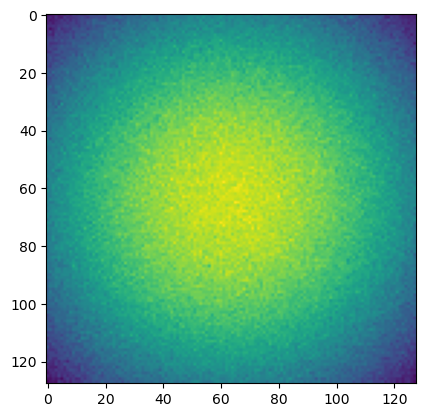

In [16]:
truesigma = 100
mean = gaussdist(truesigma)
rng = np.random.default_rng()
Obs = rng.normal(mean, 0.01) #Add noise
plt.imshow(Obs[:,:,5])


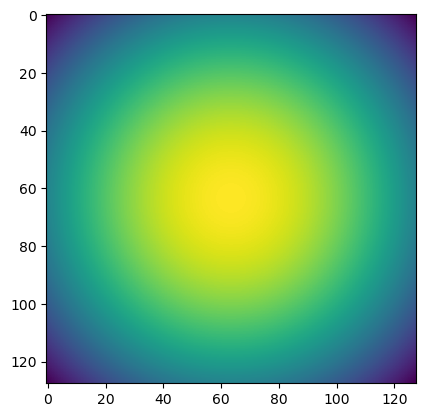

In [17]:
plt.imshow(mean[:,:,5])


In [18]:
def loglikelihood_fn(mean, observed=Obs):
    """Univariate Normal"""
    return -0.5*jnp.sum(((mean-observed)/0.01)**2)

loglikelihood = lambda x: loglikelihood_fn(**x)

inv_mass_matrix = 0.1*np.ones(1)
step_size = 1e-3
nuts = blackjax.nuts(loglikelihood, step_size, inv_mass_matrix)

In [19]:
loglikelihood_fn(mean)

Array(-1048098.4, dtype=float32)

In [20]:
from jax import lax
def progress_bar_scan(num_samples, message=None):
    "Progress bar for a JAX scan"
    if message is None:
            message = f"Running for {num_samples:,} iterations"
    tqdm_bars = {}

    if num_samples > 20:
        print_rate = int(num_samples / 20)
    else:
        print_rate = 1 # if you run the sampler for less than 20 iterations
    remainder = num_samples % print_rate

    def _define_tqdm(arg, transform):
        tqdm_bars[0] = tqdm(range(num_samples))
        tqdm_bars[0].set_description(message, refresh=False)

    def _update_tqdm(arg, transform):
        tqdm_bars[0].update(arg)

    def _update_progress_bar(iter_num):
        "Updates tqdm progress bar of a JAX scan or loop"
        _ = lax.cond(
            iter_num == 0,
            lambda _: host_callback.id_tap(_define_tqdm, None, result=iter_num),
            lambda _: iter_num,
            operand=None,
        )

        _ = lax.cond(
            # update tqdm every multiple of `print_rate` except at the end
            (iter_num % print_rate == 0) & (iter_num != num_samples-remainder),
            lambda _: host_callback.id_tap(_update_tqdm, print_rate, result=iter_num),
            lambda _: iter_num,
            operand=None,
        )

        _ = lax.cond(
            # update tqdm by `remainder`
            iter_num == num_samples-remainder,
            lambda _: host_callback.id_tap(_update_tqdm, remainder, result=iter_num),
            lambda _: iter_num,
            operand=None,
        )

    def _close_tqdm(arg, transform):
        tqdm_bars[0].close()

    def close_tqdm(result, iter_num):
        return lax.cond(
            iter_num == num_samples-1,
            lambda _: host_callback.id_tap(_close_tqdm, None, result=result),
            lambda _: result,
            operand=None,
        )


    def _progress_bar_scan(func):
        """Decorator that adds a progress bar to `body_fun` used in `lax.scan`.
        Note that `body_fun` must either be looping over `np.arange(num_samples)`,
        or be looping over a tuple who's first element is `np.arange(num_samples)`
        This means that `iter_num` is the current iteration number
        """

        def wrapper_progress_bar(carry, x):
            if type(x) is tuple:
                iter_num, *_ = x
            else:
                iter_num = x
            _update_progress_bar(iter_num)
            result = func(carry, x)
            return close_tqdm(result, iter_num)

        return wrapper_progress_bar

    return _progress_bar_scan

In [21]:
from functools import total_ordering
import jax
import jax.numpy as jnp
import operator

def scan_with_stop(f, init, xs=None, reverse=False, unroll=1, store_every=1):
  store_every = operator.index(store_every)
  assert store_every > 0

  kwds = dict(reverse=reverse, unroll=unroll)

  if store_every == 1:
    return jax.lax.scan(f, init, xs=xs, **kwds)

  N, rem = divmod(len(xs), store_every)

  if rem:
    raise ValueError("store_every must evenly divide len(xs)")

  xs = xs.reshape(N, store_every, *xs.shape[1:])

  @scan_tqdm(len(xs))
  def f_outer(carry, xs):
    poskey= carry.position.keys()
    carry, ys = jax.lax.scan(f, carry, xs=xs[1], **kwds)
    logdensitygrad = {}
    for keys in ys.logdensity_grad.keys():
        logdensitygrad[keys]=ys.logdensity_grad[keys][-1]
    position = {}
    for keys in ys.position.keys():
        position[keys]=ys.position[keys][-1]
    return carry, HMCState(position, ys.logdensity[-1], logdensitygrad)
  return jax.lax.scan(f_outer, init, xs=(np.arange(len(xs)), xs), **kwds)



In [22]:
@jax.jit
def one_step(state, rng_key):
    state, _ = nuts.step(rng_key, state)
    return state, state
def inference_loop(rng_key, kernel, initial_state, num_samples, thin=10):
    keys = jax.random.split(rng_key, num_samples)
    store_every= int(num_samples/int(num_samples/thin))
    _, states  = scan_with_stop(one_step, initial_state, keys,store_every=store_every)

    return states

In [23]:
initial_position = {"mean": np.zeros_like(mean)}
initial_state = nuts.init(initial_position)

rng_key = jax.random.key(0)
rng_key, sample_key = jax.random.split(rng_key)
%time one_step(initial_state, rng_key)
%time one_step(initial_state, rng_key)

states = inference_loop(sample_key, nuts.step, initial_state, 4_000, thin=2)

CPU times: user 3.98 s, sys: 157 ms, total: 4.14 s
Wall time: 2.98 s
CPU times: user 6.52 ms, sys: 49 μs, total: 6.57 ms
Wall time: 5.09 ms


2025-04-08 18:09:35.838032: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.
2025-04-08 18:09:37.248186: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 26.68GiB (28645132092 bytes) by rematerialization; only reduced to 31.65GiB (33982259795 bytes), down from 31.65GiB (33982259863 bytes) originally


Running for 2,000 iterations:   0%|          | 0/2000 [00:00<?, ?it/s]

In [26]:
mcmc_samples = states.position

In [27]:
mcmc_samples['mean'].shape

(2000, 128, 128, 128)

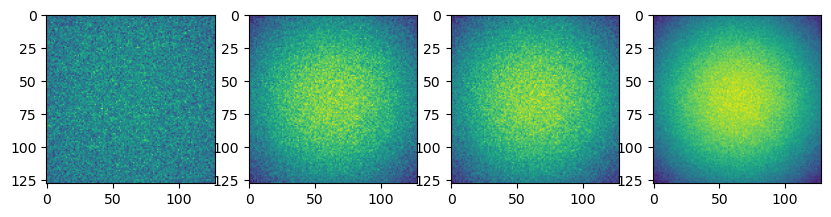

In [33]:
fig, axes = plt.subplots(1,4,figsize=(10,10))
axes[0].imshow(mcmc_samples['mean'][0,:,:,5])
axes[1].imshow(mcmc_samples['mean'][4,:,:,5])
axes[2].imshow(mcmc_samples['mean'][9,:,:,5])
axes[3].imshow(mcmc_samples['mean'][399,:,:,5])

# Check memory 

In [48]:
with jax.profiler.trace("./log"):
  try:
      del states
  except :
       pass
  jax.clear_caches()
  initial_position = {"mean": np.zeros_like(mean)}
  initial_state = nuts.init(initial_position)
  rng_key = jax.random.key(0)
  %time one_step(initial_state, rng_key)
  rng_key, sample_key = jax.random.split(rng_key)
  states = inference_loop(sample_key, nuts.step, initial_state, 800, thin=100)
  states.position['mean'].block_until_ready()

CPU times: user 4.46 s, sys: 113 ms, total: 4.57 s
Wall time: 3.42 s


2025-04-08 18:42:37.540589: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.


Running for 8 iterations:   0%|          | 0/8 [00:00<?, ?it/s]

800 steps but thin 100 (Memory usage: 18.88 GiB )	 

In [49]:
with jax.profiler.trace("./log"):
  try:
      del states
  except :
       pass
  jax.clear_caches()
  initial_position = {"mean": np.zeros_like(mean)}
  initial_state = nuts.init(initial_position)
  rng_key = jax.random.key(0)
  %time one_step(initial_state, rng_key)
  rng_key, sample_key = jax.random.split(rng_key)
  states = inference_loop(sample_key, nuts.step, initial_state, 800, thin=1)
  states.position['mean'].block_until_ready()

CPU times: user 3.87 s, sys: 74.4 ms, total: 3.94 s
Wall time: 2.99 s


800 steps without thin (Memory usage: 28.60 GiB )	 

In [45]:
with jax.profiler.trace("./log"):
  jax.clear_caches()
  try:
      del states
  except :
       pass
  initial_position = {"mean": np.zeros_like(mean)}
  initial_state = nuts.init(initial_position)
  rng_key = jax.random.key(0)
  %time one_step(initial_state, rng_key)
  rng_key, sample_key = jax.random.split(rng_key)
  states = inference_loop(sample_key, nuts.step, initial_state, 2, thin=1)
  states.position['mean'].block_until_ready()

CPU times: user 4.2 s, sys: 119 ms, total: 4.32 s
Wall time: 3.26 s


Two steps for benchmark (Memory usage: 16.13 GiB )